In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from pyiron import Project

In [3]:
data_pr = Project("import_database")
if len(pr.job_table()) == 0:
    pr.unpack("Cu_training_archive")

In [4]:
data_pr.job_table()

,id,status,chemicalformula,job,subjob,projectpath,project,timestart,timestop,totalcputime,computer,hamilton,hamversion,parentid,masterid
0,21,finished,None,df1_A1_A2_A3_EV_elast_phon,/df1_A1_A2_A3_EV_elast_phon,/home/yury/pyiron/projects/,pyiron-2021/import_database/Cu_database/,2021-02-08 10:33:52.341472,None,None,zora@cmti001#1,GenericJob,0.4,None,None
1,22,finished,None,df3_10k,/df3_10k,/home/yury/pyiron/projects/,pyiron-2021/import_database/Cu_database/,2021-02-08 10:33:53.993230,None,None,zora@cmti001#1,GenericJob,0.4,None,None
2,23,finished,None,df2_1k,/df2_1k,/home/yury/pyiron/projects/,pyiron-2021/import_database/Cu_database/,2021-02-08 10:33:54.435308,None,None,zora@cmti001#1,GenericJob,0.4,None,None


In [5]:
data_job = data_pr.load('df1_A1_A2_A3_EV_elast_phon')

# Fitting project

In [6]:
from pyiron_gpl.pacemaker.pacemaker import PaceMakerJob

In [7]:
fit_pr = Project("pacemaker_fit")

In [8]:
#fit_pr.remove_jobs_silently()#

In [9]:
job = fit_pr.create_job(job_type=PaceMakerJob, job_name="df1_cut5_pyace" ,delete_existing_job=True)

## Fit

In [10]:
cutoff = 5.0

In [11]:
job.input["potential"]= {
    "deltaSplineBins": 0.001,
    "element": "Cu",
    "fs_parameters": [1, 1, 1, 0.5],
    "npot": "FinnisSinclairShiftedScaled",
    "NameOfCutoffFunction": "cos",
    "rankmax": 3,
    "nradmax": [7,2,1],
    "lmax": [0,2,1],
    "ndensity": 2,
    "rcut": cutoff,
    "dcut": 0.01,
    "radparameters": [5.25],
    "radbase": "ChebExpCos",
}

In [12]:
job.input["fit"]= {    
    'optimizer': 'BFGS', 
    'maxiter': 150,
    'loss': {
        'kappa': 0.5,
        'L1_coeffs': 5e-7, # L1-regularization
        'L2_coeffs': 5e-7, # L2-regularization
        'w1_coeffs': 1,
        'w2_coeffs': 1,
        #radial smoothness regularization
        'w0_rad': 1e-4,    
        'w1_rad': 1e-4,
        'w2_rad': 1e-4,
    },
}

In [13]:
job.input["cutoff"] = cutoff

In [14]:
job.structure_data=data_job

In [16]:
job.executable

'/home/yury/pyiron/resources/pacemaker/bin/run_pacemakerjob_pyace.sh'

In [17]:
#job.executable.version="tf_cpu" # select the CPU-forces tensorflow version

In [18]:
job.run()

2021-02-28 01:16:07,353 - root - INFO - structure_data is TrainingContainer
2021-02-28 01:16:07,363 - root - INFO - Saving training structures dataframe into /home/yury/pyiron/projects/pyiron-2021/pacemaker_fit/df1_cut5_pyace_hdf5/df1_cut5_pyace/df_fit.pckl.gzip with pickle protocol = 4, compression = gzip


The job df1_cut5_pyace was saved and received the ID: 256


In [19]:
fit_pr.job_table(full_table=True)

,id,status,chemicalformula,job,subjob,projectpath,project,timestart,timestop,totalcputime,computer,hamilton,hamversion,parentid,masterid
0,62,finished,None,df1_cut5,/df1_cut5,/home/yury/pyiron/projects/,pyiron-2021/pacemaker_fit/,2021-02-26 18:00:20.326459,2021-02-26 18:02:25.068815,124.0,pyiron@dell-inspiron#1,PaceMakerJob,0.1,None,None
1,256,finished,None,df1_cut5_pyace,/df1_cut5_pyace,/home/yury/pyiron/projects/,pyiron-2021/pacemaker_fit/,2021-02-28 01:16:07.713672,2021-02-28 01:20:43.280739,275.0,pyiron@dell-inspiron#1,PaceMakerJob,0.1,None,None


Text(0, 0.5, 'Loss')

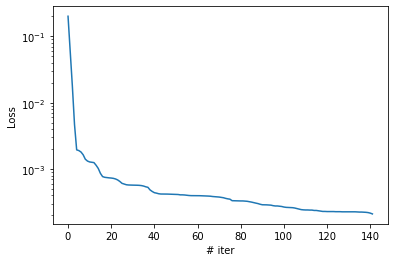

In [20]:
plt.plot(job["output/log/loss"])
plt.yscale('log')
plt.xlabel("# iter")
plt.ylabel("Loss")

Text(0, 0.5, 'Energy RMSE, meV/atom')

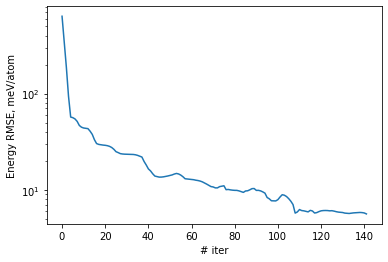

In [21]:
plt.plot(job["output/log/rmse_energy"])
plt.yscale('log')
plt.xlabel("# iter")
plt.ylabel("Energy RMSE, meV/atom")

Text(0, 0.5, 'Forces RMSE, meV/Ang/structure')

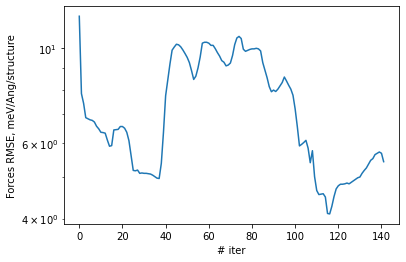

In [22]:
plt.plot(job["output/log/rmse_forces"])
plt.yscale('log')
plt.xlabel("# iter")
plt.ylabel("Forces RMSE, meV/Ang/structure")

# Overview of the fitted potential internals

In [23]:
from pyace import *

In [24]:
final_potential = job.get_final_potential()
final_basis_set = ACEBBasisSet(final_potential)

For single-species potential there is only one **species block** for *Cu*:

In [25]:
len(final_potential.funcspecs_blocks)

1

In [26]:
Cu_block = final_potential.funcspecs_blocks[0]

Basic definitions and notations:

* Radial functions: $R_{nl}(r) = \sum_k c_{nlk} g_k(r)$


* Spherical harmonics:  $  Y_{lm}(\hat{\pmb{r}}_{ji}) $


* Basis function: $\phi_{\mu_j \mu_i nlm}(\pmb{r}_{ji}) = R_{nl}^{\mu_j \mu_i}(r_{ji}) Y_{lm}(\hat{\pmb{r}}_{ji}) $


* Atomic base (A-functions): $ A_{i \mu n l m} = \sum_j \delta_{\mu \mu_j} \phi_{\mu_j\mu_i nlm}(\pmb{r}_{ji})  $


* Product of atomic base: $ \pmb{A}_{i\pmb{\mu n l m}} =  \prod_{t = 1}^{\nu} A_{i \mu_t n_t l_t m_t}  $


* Equivariant basis (B-functions):  $  {B}_{i\pmb{\mu n l L}}  = \sum_{\pmb{m}}   \left(
\begin{array}{c} 
\pmb{l m} \\
\pmb{L M}
\end{array}
L_R
\right)  \pmb{A}_{i\pmb{\mu n l m}}  $ ,

where $ \left(\begin{array}{c} \pmb{l m} \\ \pmb{L M}\end{array} L_R\right) $ is *generalized Clebsh-Gordan coefficients* 


* Atomic property (densities) $ \rho_i^{(p)} = \sum_{\pmb{\mu n l L}} {c}^{(p)}_{\mu_i\pmb{\mu n l L}} {B}_{i\pmb{\mu n l L}}  $


* Atomic energy: $ E_i = F(\rho_i^{(1)}, \dots,\rho_i^{(P)} )  $

radial coefficients $c_{nlk}$:

In [27]:
np.shape(Cu_block.radcoefficients)

(2, 3, 7)

Visualize the radial basis functions ($g_k$) and radial functions ($R_{nl}$) and their derivatives:

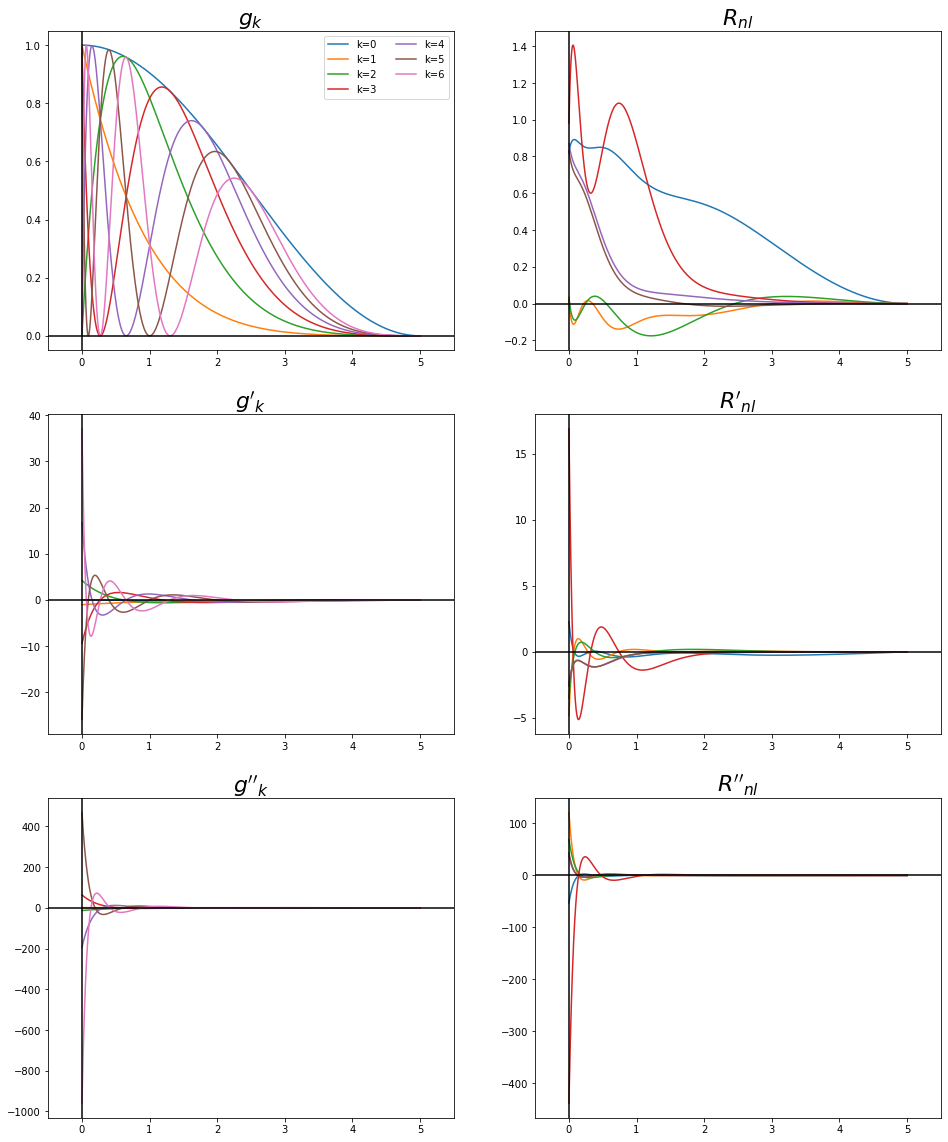

In [28]:
RadialFunctionsVisualization(final_basis_set).plot()

Total number of basis functions

In [29]:
len(Cu_block.funcspecs)

18

List of B-basis functions $ {B}_{i\pmb{\mu n l L}}$: $\pmb{\mu} = $ `elements`, $\pmb{n} = $ `ns`, $\pmb{l} = $ `ls`, $\pmb{L} = $ `LS`)  and corresponding coefficients $ {c}^{(p)}_{\mu_i\pmb{\mu n l L}} =$ `coeffs` for two densities

In [30]:
Cu_block.funcspecs

[BBasisFunctionSpecification(elements=[Cu,Cu],  ns=[1],  ls=[0],  coeffs=[-0.947664,-0.20673]),
 BBasisFunctionSpecification(elements=[Cu,Cu],  ns=[2],  ls=[0],  coeffs=[0.127744,0.0378252]),
 BBasisFunctionSpecification(elements=[Cu,Cu],  ns=[3],  ls=[0],  coeffs=[0.395046,0.128133]),
 BBasisFunctionSpecification(elements=[Cu,Cu],  ns=[4],  ls=[0],  coeffs=[0.490821,0.17195]),
 BBasisFunctionSpecification(elements=[Cu,Cu],  ns=[5],  ls=[0],  coeffs=[0.192457,0.100866]),
 BBasisFunctionSpecification(elements=[Cu,Cu],  ns=[6],  ls=[0],  coeffs=[-0.381239,-0.0435031]),
 BBasisFunctionSpecification(elements=[Cu,Cu],  ns=[7],  ls=[0],  coeffs=[-0.717072,-0.124286]),
 BBasisFunctionSpecification(elements=[Cu,Cu,Cu],  ns=[1,1],  ls=[0,0],  coeffs=[0.176241,0.135483]),
 BBasisFunctionSpecification(elements=[Cu,Cu,Cu],  ns=[1,1],  ls=[1,1],  coeffs=[0.0335965,0.00542081]),
 BBasisFunctionSpecification(elements=[Cu,Cu,Cu],  ns=[1,1],  ls=[2,2],  coeffs=[0.361527,0.101027]),
 BBasisFunctionSpeci

# Test fitted potential

In [31]:
test_pr = Project("test_ace_potential")

In [32]:
test_pr.remove_jobs_silently()

In [33]:
test_pr.job_table()

""


In [34]:
cu_ace_potential = job.get_lammps_potential()

In [35]:
cu_ace_potential


,Config,Filename,Model,Name,Species
0,"[pair_style pace\n, pair_coeff * * /home/yury/pyiron/projects/pyiron-2021/pacemaker_fit/df1_cut5_pyace_hdf5/df1_cut5_pyace/df1_cut5_pyace.ace Cu\n]",,ACE,df1_cut5_pyace,[Cu]


## Optimization

In [36]:
lammps_job = test_pr.create.job.Lammps("opt_lammps", delete_existing_job=True)

In [37]:
lammps_job.executable.version="2020.12.24_pace"

In [38]:
lammps_job.potential = cu_ace_potential

In [39]:
lammps_job.structure = test_pr.create.structure.ase_bulk("Cu","fcc",cubic=True)

In [40]:
lammps_job.calc_minimize(pressure=0.0)

In [41]:
lammps_job.run()

The job opt_lammps was saved and received the ID: 257


In [42]:
test_pr.job_table()

,id,status,chemicalformula,job,subjob,projectpath,project,timestart,timestop,totalcputime,computer,hamilton,hamversion,parentid,masterid
0,257,finished,Cu4,opt_lammps,/opt_lammps,/home/yury/pyiron/projects/,pyiron-2021/test_ace_potential/,2021-02-28 01:20:51.247184,2021-02-28 01:20:52.024520,0.0,pyiron@dell-inspiron#1,Lammps,0.1,None,None


## Elastic matrix

In [43]:
elmat_job = test_pr.create.job.ElasticMatrixJob("elmat", delete_existing_job=True)

In [44]:
elmat_job.input["eps_range"] = 0.05

In [45]:
ref_job = test_pr.create.job.Lammps("ref_job", delete_existing_job=True)

In [46]:
ref_job.executable.version="2020.12.24_pace"

In [47]:
ref_job.potential = cu_ace_potential

In [48]:
ref_job.structure = lammps_job.get_structure()

In [49]:
elmat_job.ref_job = ref_job

In [50]:
elmat_job.run()

The job elmat was saved and received the ID: 258
The job s_e_0 was saved and received the ID: 259
The job s_01_e_m0_05000 was saved and received the ID: 260
The job s_01_e_m0_02500 was saved and received the ID: 261
The job s_01_e_0_02500 was saved and received the ID: 262
The job s_01_e_0_05000 was saved and received the ID: 263
The job s_08_e_m0_05000 was saved and received the ID: 264
The job s_08_e_m0_02500 was saved and received the ID: 265
The job s_08_e_0_02500 was saved and received the ID: 266
The job s_08_e_0_05000 was saved and received the ID: 267
The job s_23_e_m0_05000 was saved and received the ID: 268
The job s_23_e_m0_02500 was saved and received the ID: 269
The job s_23_e_0_02500 was saved and received the ID: 270
The job s_23_e_0_05000 was saved and received the ID: 271


In [51]:
elast_val=elmat_job["output/elasticmatrix"]

Text(0, 0.5, 'E, eV')

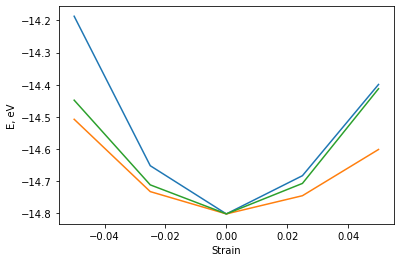

In [52]:
ses = np.array(elast_val['strain_energy'])

for se in ses:
    plt.plot(se[:,0], se[:,1])
    
plt.xlabel("Strain")
plt.ylabel("E, eV")

In [54]:
C=elast_val["C"]

In [55]:
print("C11 = {:.1f} GPa".format(C[0,0]))
print("C12 = {:.1f} GPa".format(C[0,1]))
print("C44 = {:.1f} GPa".format(C[3,3]))

C11 = 210.4 GPa
C12 = 120.1 GPa
C44 = 83.0 GPa


## Phonons

In [57]:
phon_job = test_pr.create.job.PhonopyJob("phon_job", delete_existing_job=True)

ref_job = test_pr.create.job.Lammps("ref_job", delete_existing_job=True)

ref_job.executable.version="2020.12.24_pace"

ref_job.potential = cu_ace_potential

ref_job.structure = lammps_job.get_structure()

phon_job.input['dos_mesh']=75

phon_job.ref_job = ref_job

phon_job.run()

The job phon_job was saved and received the ID: 272
The job ref_job_0 was saved and received the ID: 273


# Comparison with some DFT reference data

In [58]:
from structdbrest import StructDBLightRester

In [59]:
rest = StructDBLightRester(token="workshop2021")

In [60]:
fhi_calc = rest.query_calculator_types("FHI%aims%")[0]

Querying...done
Response successful, size = 7.20 kB, time = 0.27 s
1  entries received


In [61]:
dft_elast_prop = rest.query_properties(rest.PropertyTypes.ELASTIC_MATRIX, composition="Cu-%", strukturbericht="A1", 
                      calculator_name=fhi_calc.NAME)[0]

Querying...done
Response successful, size = 37.78 kB, time = 0.45 s
1  entries received


In [62]:
C_dft=dft_elast_prop.value["C"]

In [63]:
print("C11 = {:.1f} GPa / DFT C11={:.1f} GPa".format(C[0,0], C_dft[0][0]))
print("C12 = {:.1f} GPa / DFT C11={:.1f} GPa".format(C[0,1], C_dft[0][1]))
print("C44 = {:.1f} GPa / DFT C11={:.1f} GPa".format(C[3,3], C_dft[3][3]))

C11 = 210.4 GPa / DFT C11=176.9 GPa
C12 = 120.1 GPa / DFT C11=131.7 GPa
C44 = 83.0 GPa / DFT C11=82.5 GPa


In [64]:
dft_phon_prop = rest.query_properties(rest.PropertyTypes.PHONONS, composition="Cu-%", strukturbericht="A1", 
                      calculator_name=fhi_calc.NAME)[0]

Querying...done
Response successful, size = 22.50 kB, time = 0.24 s
1  entries received


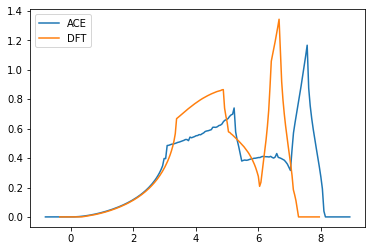

In [65]:
plt.plot(phon_job["output/dos_energies"], phon_job["output/dos_total"]/4, label="ACE")
plt.plot(dft_phon_prop.value["dos_energies"],  dft_phon_prop.value["dos_total"], label="DFT")
plt.legend()